In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
np.set_printoptions(suppress=True)

In [3]:
a50_etf = pd.read_excel('/Users/a50etf已处理数据.xlsx')

前文已对收益率序列进行描述性统计，发现序列自相关性较差，存在波动聚集现象，分布的尾部偏差较大，不符合标准正态分布。

In [4]:
a50_etf

,date,open,high,low,close,Rt,log_Rt,volatility_20
0,2016-01-04,2.411,2.413,2.271,2.278,NaN,NaN,NaN
1,2016-01-05,2.260,2.311,2.230,2.286,0.003500,0.003506,NaN
2,2016-01-06,2.290,2.320,2.275,2.317,0.013379,0.013470,NaN
3,2016-01-07,2.286,2.286,2.165,2.177,-0.064309,-0.062325,NaN
4,2016-01-08,2.236,2.259,2.156,2.219,0.018927,0.019109,NaN
...,...,...,...,...,...,...,...,...
1248,2021-02-22,4.002,4.005,3.866,3.873,-0.032275,-0.031765,0.013483
1249,2021-02-23,3.849,3.927,3.845,3.886,0.003345,0.003351,0.013245
1250,2021-02-24,3.887,3.896,3.752,3.788,-0.025871,-0.025542,0.014530
1251,2021-02-25,3.824,3.862,3.804,3.843,0.014312,0.014415,0.014708


画出对数收益率平方的图

In [54]:
def square_return_fig(rt):
    
    Rt2 = rt**2
    
    Rt2.plot(figsize = (12 , 6) , 
             lw = 0.9 , 
             title = 'squared return')
    plt.style.context('ggplot')
    return
    

In [ ]:
square_return_fig(a50_etf.log_Rt)
days= [i.date() for i in a50_etf['date']]
plt.xticks(range(len(days))[::200],days[::200])

可以从上面收益率平方的图中观察出，a50收益率存在波动聚集现象，即异方差性。

In [7]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

下面对收益率平方序列进行自相关性检验，LB检验arch效应

In [62]:
def whitenoise_test(ts):
    from statsmodels.stats.diagnostic import acorr_ljungbox
    q,p = acorr_ljungbox(ts)
    t = sm.tsa.stattools.adfuller(ts)
    t = float(t[1])
    print("p value: " , t) 

    with plt.style.context('ggplot'):
        fig = plt.figure(figsize = (10, 4))
        axes = fig.subplots(1,2)
        
    axes[0].plot(q, label = 'Q statistic' , c = 'b')
    axes[0].set_ylabel('Q')

    axes[1].plot(p, label = 'p value' , c = 'b')
    axes[1].set_ylabel('P')

    axes[0].legend()
    axes[1].legend()

    plt.tight_layout()
    return

对 对数收益率平方进行LB检验

In [9]:
Rt2 = a50_etf.log_Rt.dropna()


p value:  3.62122572905955e-13


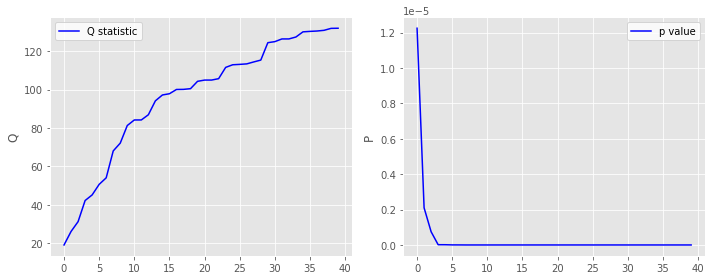

In [63]:
whitenoise_test(Rt2**2)  

对对数收益率进行LB检验

p value:  3.5388477849526606e-23


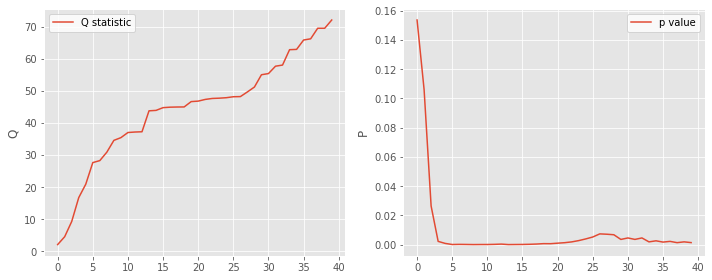

In [11]:
whitenoise_test(Rt2)

p统计量拒绝原假设，收益率序列存在ARCH效益

下面对收益率序列建立GARCH模型

首先建立ARMA(p,q)模型确定滞后阶数p和q

In [12]:
def arma_test(rt):
    plt.style.context('ggplot')
    fig = plt.figure(figsize = (8 , 6))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(rt , lags = 30 , ax = ax1)
    
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(rt , lags = 30 , ax = ax2)
    
    plt.tight_layout()
    return

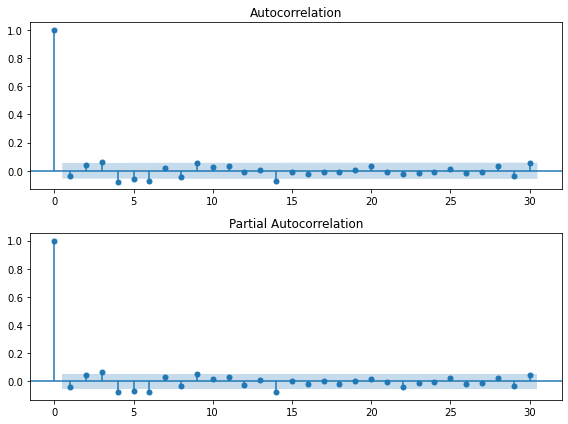

In [13]:
arma_test(Rt2)

In [78]:
def _get_best_model(TS):
    best_aic = np.inf
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    tmp_bic = tmp_mdl.bic
                    print(i,d,j,tmp_aic,tmp_bic)
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue

    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl

In [79]:
_get_best_model(Rt2)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmode

0 0 1 -7445.836721904738 -7435.571726801418
0 0 2 -7447.580605450939 -7432.1831127959595
0 0 3 -7451.836427552564 -7431.306437345924
0 0 4 -7458.105001981103 -7432.442514222803
0 1 1 -7431.282374482729 -7421.018977461796


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


0 1 2 -7431.074878530708 -7415.6797829993075


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


0 1 3 -7432.787258164097 -7412.260464122229


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


0 1 4 -7436.99151928667 -7411.333026734335
1 0 0 -7446.001736136313 -7435.736741032993
1 0 1 -7444.4931485998895 -7429.09565594491
1 0 2 -7446.954640334601 -7426.424650127961


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


1 0 3 -7462.795551637424 -7437.133063879124


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


1 0 4 -7461.803191142191 -7431.008205832231
1 1 0 -6955.314518166204 -6945.05112114527


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


1 1 1 -7431.241492962907 -7415.846397431506


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


1 1 2 -7434.358739938047 -7413.831945896179


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


1 1 3 -7437.276345782575 -7411.61785323024


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


1 1 4 -7447.953984442405 -7417.163793379604
2 0 0 -7446.409945193374 -7431.012452538394
2 0 1 -7445.482716706905 -7424.952726500265


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


2 0 2 -7454.244672950204 -7428.5821851919045


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


2 0 3 -7453.285260992527 -7422.490275682567


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


2 0 4 -7463.18828627328 -7427.26080341166
2 1 0 -7135.97371603467 -7120.57862050327


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


2 1 1 -7431.62036286339 -7411.093568821522


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


2 1 2 -7438.2573572810525 -7412.598864728718


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


2 1 3 -7441.7825491047515 -7410.99235804195


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


2 1 4 -7446.111264376661 -7410.189374803393
3 0 0 -7449.98344270395 -7429.45345249731


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


3 0 1 -7460.776729641935 -7435.114241883635
3 0 2 -7453.0550810041805 -7422.260095694221


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


3 0 3 -7463.692316870061 -7427.7648340084415


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


3 0 4 -7473.950072254407 -7432.890091841126
3 1 0 -7166.708467410663 -7146.181673368795


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


3 1 1 -7435.140439642224 -7409.481947089889


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


3 1 2 -7445.944100988003 -7415.153909925201


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


3 1 3 -7444.121715433097 -7408.199825859829


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


3 1 4 -7448.858031616233 -7407.804443532498
4 0 0 -7455.040113068691 -7429.3776253103915
4 0 1 -7460.671892465012 -7429.876907155052


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


4 0 2 -7463.513155180131 -7427.585672318512


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


4 0 3 -7474.60936482539 -7433.549384412109


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


4 0 4 -7472.625203859427 -7426.432725894486
4 1 0 -7194.017362415556 -7168.358869863221


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


4 1 1 -7440.252165985488 -7409.461974922687
aic: -7474.60936 | order: (4, 0, 3)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmode

(-7474.60936482539,
 (4, 0, 3),
 <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x7fd66edfd160>)

自相关系数在4阶超出单位根，偏自相关系数在3阶超出单位根，可建立ARMA(4,3)模型

于是我们确定参数 p=4，q=3

In [66]:
log_Rt = a50_etf.log_Rt.dropna() * 100
a50_garch = arch_model(log_Rt ,
                       p = 4,
                       q = 3,
                       )
garch_result = a50_garch.fit(update_freq = 0)
print(garch_result.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1905.6102098248793
            Iterations: 18
            Function evaluations: 194
            Gradient evaluations: 18
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 log_Rt   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1905.61
Distribution:                  Normal   AIC:                           3829.22
Method:            Maximum Likelihood   BIC:                           3875.41
                                        No. Observations:                 1252
Date:                Tue, Apr 06 2021   Df Residuals:                     1251
Time:                        22:09:25   Df Model:                            1
                                 Mean Model                                
  

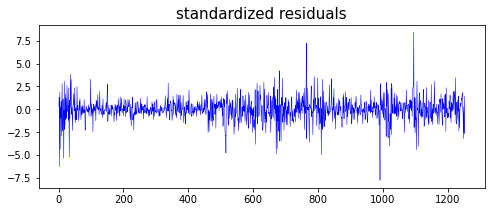

In [17]:
garch_result.resid.plot(figsize = (8 , 3),
                        lw = 0.5,
                        color = 'b')
plt.style.context('ggplot')
plt.title('standardized residuals' , size = 15)
plt.show()

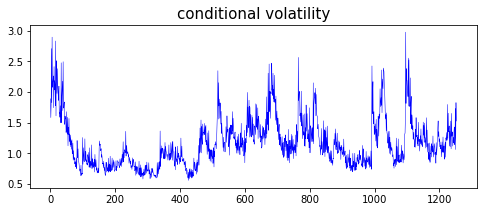

In [18]:
garch_result.conditional_volatility.plot(figsize = (8 , 3) , color = 'b' , lw = 0.5)
plt.style.context('ggplot')
plt.title('conditional volatility' , size = 15)
plt.show()

通过AIC准则获取最佳GARCH模型的p,q

In [82]:
def best_garch_family(rt):
    best_aic = np.inf 
    best_order = None 
    best_mdl = None
    
    for o in range(0,2):       
        for dist in ('normal' , 'studentst' , 'skewstudent' , 'generalized error'):
            try:
                tmp_mdl = arch_model(rt, p = 4 , o = o , q = 3 , dist = dist).fit(update_freq = 0)
                tmp_aic = tmp_mdl.aic
                tmp_bic = tmp_mdl.bic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (o , dist)
                    best_mdl = tmp_mdl
                print(dist,o,tmp_mdl.aic,tmp_mdl.bic)
            except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl

In [83]:
best_garch_family(Rt2)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3837.832779971034
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 3
normal 0 -7657.665559942068 -7611.473081977128
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 3158.238837247446
            Iterations: 31
            Function evaluations: 396
            Gradient evaluations: 27
studentst 0 6336.477674494892 6387.802650011493
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1152.9867957966733
            Iterations: 8
            Function evaluations: 110
            Gradient evaluations: 7
skewstudent 0 2327.9735915933466 2384.4310646616073


/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:740: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Optimization terminated successfully    (Exit mode 0)
            Current function value: -3892.10351748895
            Iterations: 7
            Function evaluations: 51
            Gradient evaluations: 3
generalized error 0 -7764.2070349779 -7712.882059461299
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3843.7592179177736
            Iterations: 8
            Function evaluations: 65
            Gradient evaluations: 4
normal 1 -7667.518435835547 -7616.193460318947
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 674315.9481082273
            Iterations: 24
            Function evaluations: 320
            Gradient evaluations: 21
studentst 1 1348653.8962164547 1348710.353689523


/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Inequality constraints incompatible    (Exit mode 4)
            Current function value: 144285.15551708487
            Iterations: 65
            Function evaluations: 998
            Gradient evaluations: 62
skewstudent 1 288594.31103416975 288655.9010047897
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3895.96148641856
            Iterations: 5
            Function evaluations: 12
            Gradient evaluations: 1
generalized error 1 -7769.92297283712 -7713.465499768859
aic: -7769.92297 | order: (1, 'generalized error')


/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:740: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


(-7769.92297283712,
 (1, 'generalized error'),
                          Constant Mean - GJR-GARCH Model Results                          
 Dep. Variable:                             log_Rt   R-squared:                       0.000
 Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
 Vol Model:                              GJR-GARCH   Log-Likelihood:                3895.96
 Distribution:      Generalized Error Distribution   AIC:                          -7769.92
 Method:                        Maximum Likelihood   BIC:                          -7713.47
                                                     No. Observations:                 1252
 Date:                            Tue, Apr 06 2021   Df Residuals:                     1251
 Time:                                    22:52:26   Df Model:                            1
                                   Mean Model                                 
                  coef    std err          t  

通过AIC，BIC准则最小判断拟合效果最佳的模型是 GJR-GARCH-GED

利用该模型一步预测未来30天的波动率

In [22]:
a50_garch = arch_model(log_Rt ,
                       p = 4,
                       o = 1,
                       q = 3,
                       dist = 'ged')
garch_result = a50_garch.fit(update_freq = 0)
print(garch_result.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1846.7932477396616
            Iterations: 27
            Function evaluations: 351
            Gradient evaluations: 27
                         Constant Mean - GJR-GARCH Model Results                          
Dep. Variable:                             log_Rt   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                              GJR-GARCH   Log-Likelihood:               -1846.79
Distribution:      Generalized Error Distribution   AIC:                           3715.59
Method:                        Maximum Likelihood   BIC:                           3772.04
                                                    No. Observations:                 1252
Date:                            Tue, Apr 06 2021   Df Residuals:                     1251
Time:                                    09:45:13   Df Model:

In [23]:
forecasts = garch_result.forecast(horizon = 30)
forecasts_variance = forecasts.variance
print(forecasts_variance)

          h.01      h.02      h.03      h.04      h.05      h.06      h.07  \
1          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
5          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
...        ...       ...       ...       ...       ...       ...       ...   
1248       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1249       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1250       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1251       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1252  2.615419  2.612212  2.451229  2.606716  2.523928  2.479343  2.514864   

          h.08      h.09      h.10  ...      h.21      h.22    

注：简单处理为一步预测，即对预测日过去200天时间序列进行建模，用模型预测未来30天的波动率。

因为后面要计算的两个隐含波动率指数（BS，iVIX）都是30天的月波动率，为使得三个指数尺度一致，需要用GARCH模型向外预测30天，而不能只预测1天。

下一步将预测出的30天波动了取等权重平均数作为预测日的波动率指数。

In [24]:
gh30 = forecasts_variance.iloc[-1,:].mean()
gh30

2.3761411063373195

此处取等权重平均值也是一种简化处理方式，另外的改进方式可以有两种：

1）预测未来1天的日波动率 $\sigma_{day}$，用 $\sigma_{mon} = \sqrt{20} \sigma_{day}$ 转化为30天的月波动率

2）滚动预测未来30天的日波动率，求平均值。这种方法是：先预测未来1天的波动率，将预测出的数纳入建模的窗口重新建模，站在t+1天预测t+2天的波动率，重复上述步骤，直到获得30个数。

In [25]:
log_Rt

1       0.350570
2       1.346968
3      -6.232546
4       1.910886
5      -4.328484
          ...   
1248   -3.176484
1249    0.335095
1250   -2.554218
1251    1.441514
1252   -2.636588
Name: log_Rt, Length: 1252, dtype: float64

接下来使用该模型对回测期内的日波动率进行滚动预测

首先选取我们需要预测的数据区间，从2018-01-04 到 2020-12-31 

    先将date列设为dataframe的index，并且改为datetime格式以便索引

In [26]:
a50_etf['date'] = pd.to_datetime(a50_etf['date'])
a50_etf.set_index('date' , inplace = True)

In [27]:
a50_etf.index.date

array([datetime.date(2016, 1, 4), datetime.date(2016, 1, 5),
       datetime.date(2016, 1, 6), ..., datetime.date(2021, 2, 24),
       datetime.date(2021, 2, 25), datetime.date(2021, 2, 26)],
      dtype=object)

In [28]:
from scipy.stats import kurtosis

In [29]:
Rt_window = a50_etf.log_Rt.loc[(a50_etf.index > pd.to_datetime('2018-01-01')) & (a50_etf.index < pd.to_datetime('2020-12-31'))].dropna()
kurtosis(Rt_window)                                                                                        

5.012925475991146

以预测窗口期前200个交易日的对数收益率建立GARCH模型，并滚动拟合，选取最佳的模型预测未来1天的波动率

In [30]:
garch_volatility = []

In [31]:
def garch_forecast(data):
    data = arch_model(data ,
                      p = 4,
                      o = 1,
                      q = 3,
                      dist = 'ged')
    garch_result = data.fit(update_freq = 0)
    forecasts = garch_result.forecast(horizon = 30)
    forecasts_variance = forecasts.variance
    garch_volatility.append(forecasts_variance.iloc[-1,:].mean())
    return forecasts_variance.iloc[-1,0]

In [32]:
log_Rt.rolling(200).apply(garch_forecast)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 268.2230929740122
            Iterations: 22
            Function evaluations: 287
            Gradient evaluations: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: 267.94040018414955
            Iterations: 20
            Function evaluations: 257
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: 268.2996150956974
            Iterations: 27
            Function evaluations: 348
            Gradient evaluations: 27
Optimization terminated successfully    (Exit mode 0)
            Current function value: 265.02948094995475
            Iterations: 23
            Function evaluations: 293
            Gradient evaluations: 23
Optimization terminated successfully    (Exit mode 0)
            Current function value: 262.95137921074195
            Iterations: 34
            Function e

Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.99580470509352
            Iterations: 21
            Function evaluations: 267
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: 227.06017515417338
            Iterations: 18
            Function evaluations: 228
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.10724994068426
            Iterations: 19
            Function evaluations: 241
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 223.54776344189565
            Iterations: 18
            Function evaluations: 228
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 224.11120927497942
            Iterations: 17
            Function

Optimization terminated successfully    (Exit mode 0)
            Current function value: 206.12546050038543
            Iterations: 26
            Function evaluations: 327
            Gradient evaluations: 26
Optimization terminated successfully    (Exit mode 0)
            Current function value: 206.84017603523787
            Iterations: 20
            Function evaluations: 250
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: 203.5930197318375
            Iterations: 33
            Function evaluations: 406
            Gradient evaluations: 32
Optimization terminated successfully    (Exit mode 0)
            Current function value: 200.8999527756124
            Iterations: 20
            Function evaluations: 257
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: 200.9892835982085
            Iterations: 19
            Function ev

Optimization terminated successfully    (Exit mode 0)
            Current function value: 186.422909577854
            Iterations: 15
            Function evaluations: 191
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: 186.31062709152903
            Iterations: 13
            Function evaluations: 166
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: 186.21573153025037
            Iterations: 13
            Function evaluations: 168
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: 185.6593872682507
            Iterations: 14
            Function evaluations: 181
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: 185.00398520064948
            Iterations: 16
            Function ev

Optimization terminated successfully    (Exit mode 0)
            Current function value: 191.97633579815812
            Iterations: 22
            Function evaluations: 280
            Gradient evaluations: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: 192.57329303446716
            Iterations: 18
            Function evaluations: 231
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 192.84929056202049
            Iterations: 17
            Function evaluations: 218
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 195.5727994738213
            Iterations: 22
            Function evaluations: 280
            Gradient evaluations: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: 195.6598283371066
            Iterations: 34
            Function e

Optimization terminated successfully    (Exit mode 0)
            Current function value: 207.54805424513322
            Iterations: 28
            Function evaluations: 358
            Gradient evaluations: 28
Optimization terminated successfully    (Exit mode 0)
            Current function value: 207.45564617285612
            Iterations: 22
            Function evaluations: 279
            Gradient evaluations: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: 207.93714799825062
            Iterations: 21
            Function evaluations: 268
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: 207.3672407649209
            Iterations: 20
            Function evaluations: 257
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: 206.21193202635692
            Iterations: 25
            Function 

Optimization terminated successfully    (Exit mode 0)
            Current function value: 191.72571845453547
            Iterations: 18
            Function evaluations: 234
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 192.04365212640897
            Iterations: 17
            Function evaluations: 225
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 191.22451812649106
            Iterations: 23
            Function evaluations: 297
            Gradient evaluations: 23
Optimization terminated successfully    (Exit mode 0)
            Current function value: 190.4262289017915
            Iterations: 22
            Function evaluations: 283
            Gradient evaluations: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: 190.48074072292064
            Iterations: 18
            Function 

Optimization terminated successfully    (Exit mode 0)
            Current function value: 218.33925131932318
            Iterations: 17
            Function evaluations: 217
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 218.7829333298302
            Iterations: 15
            Function evaluations: 193
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: 219.49569495346364
            Iterations: 19
            Function evaluations: 242
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 222.55671438451387
            Iterations: 20
            Function evaluations: 255
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: 222.70800316618013
            Iterations: 22
            Function 

Optimization terminated successfully    (Exit mode 0)
            Current function value: 256.13543697772684
            Iterations: 18
            Function evaluations: 229
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 257.5512758708976
            Iterations: 17
            Function evaluations: 217
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 258.37871918863914
            Iterations: 18
            Function evaluations: 232
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 259.31947469908005
            Iterations: 18
            Function evaluations: 230
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 259.791248018761
            Iterations: 17
            Function ev

Optimization terminated successfully    (Exit mode 0)
            Current function value: 273.2641514477337
            Iterations: 16
            Function evaluations: 208
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: 274.06824023945614
            Iterations: 17
            Function evaluations: 218
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 273.8782301346413
            Iterations: 17
            Function evaluations: 218
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 272.56022860345473
            Iterations: 17
            Function evaluations: 218
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 272.87334848362946
            Iterations: 17
            Function e

Optimization terminated successfully    (Exit mode 0)
            Current function value: 279.01509987605266
            Iterations: 18
            Function evaluations: 222
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 281.47909824762365
            Iterations: 20
            Function evaluations: 246
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 282.0349618464179
            Iterations: 16
            Function evaluations: 207
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: 283.8860984825187
            Iterations: 17
            Function evaluations: 219
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 288.2413907059379
            Iterations: 19
            Function ev

Optimization terminated successfully    (Exit mode 0)
            Current function value: 321.69222153434237
            Iterations: 17
            Function evaluations: 218
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 322.05314238823917
            Iterations: 16
            Function evaluations: 206
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: 322.4323488715214
            Iterations: 18
            Function evaluations: 231
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 323.8947153491415
            Iterations: 16
            Function evaluations: 204
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: 323.8988353012089
            Iterations: 17
            Function ev

Optimization terminated successfully    (Exit mode 0)
            Current function value: 347.22920544943725
            Iterations: 18
            Function evaluations: 230
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 348.3827098976327
            Iterations: 18
            Function evaluations: 232
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 347.673407867674
            Iterations: 18
            Function evaluations: 230
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 348.4759123630638
            Iterations: 18
            Function evaluations: 229
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 350.7199448490553
            Iterations: 18
            Function eval

Optimization terminated successfully    (Exit mode 0)
            Current function value: 341.0783004325136
            Iterations: 17
            Function evaluations: 220
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 340.3726671843205
            Iterations: 16
            Function evaluations: 208
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: 340.246552053947
            Iterations: 17
            Function evaluations: 220
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 339.9884440505191
            Iterations: 17
            Function evaluations: 219
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 340.73238217325815
            Iterations: 18
            Function eval

Optimization terminated successfully    (Exit mode 0)
            Current function value: 349.05188411963377
            Iterations: 17
            Function evaluations: 216
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 349.21404951219176
            Iterations: 16
            Function evaluations: 205
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: 348.61017160372387
            Iterations: 16
            Function evaluations: 206
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: 349.47029531000726
            Iterations: 17
            Function evaluations: 216
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 349.82603227748393
            Iterations: 15
            Function

Optimization terminated successfully    (Exit mode 0)
            Current function value: 355.041363542103
            Iterations: 22
            Function evaluations: 282
            Gradient evaluations: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: 352.5817114013221
            Iterations: 21
            Function evaluations: 266
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: 353.4657548771743
            Iterations: 21
            Function evaluations: 266
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: 353.22781973502526
            Iterations: 23
            Function evaluations: 295
            Gradient evaluations: 23
Optimization terminated successfully    (Exit mode 0)
            Current function value: 357.42534314676567
            Iterations: 17
            Function eva

Optimization terminated successfully    (Exit mode 0)
            Current function value: 352.1962817753561
            Iterations: 23
            Function evaluations: 294
            Gradient evaluations: 23
Optimization terminated successfully    (Exit mode 0)
            Current function value: 351.9844763639465
            Iterations: 18
            Function evaluations: 229
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 351.43759609772076
            Iterations: 24
            Function evaluations: 305
            Gradient evaluations: 24
Optimization terminated successfully    (Exit mode 0)
            Current function value: 351.185718931764
            Iterations: 17
            Function evaluations: 219
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 353.2333611952619
            Iterations: 22
            Function eval

Optimization terminated successfully    (Exit mode 0)
            Current function value: 325.8811558508866
            Iterations: 21
            Function evaluations: 274
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: 324.293870714339
            Iterations: 39
            Function evaluations: 497
            Gradient evaluations: 39
Optimization terminated successfully    (Exit mode 0)
            Current function value: 324.575743767645
            Iterations: 24
            Function evaluations: 312
            Gradient evaluations: 24
Optimization terminated successfully    (Exit mode 0)
            Current function value: 325.8406703660488
            Iterations: 24
            Function evaluations: 303
            Gradient evaluations: 24
Optimization terminated successfully    (Exit mode 0)
            Current function value: 322.7255915957028
            Iterations: 17
            Function evalua

Optimization terminated successfully    (Exit mode 0)
            Current function value: 310.7890262842326
            Iterations: 38
            Function evaluations: 486
            Gradient evaluations: 38
Optimization terminated successfully    (Exit mode 0)
            Current function value: 310.9933255313241
            Iterations: 27
            Function evaluations: 349
            Gradient evaluations: 27
Optimization terminated successfully    (Exit mode 0)
            Current function value: 310.3677303967421
            Iterations: 30
            Function evaluations: 381
            Gradient evaluations: 30
Optimization terminated successfully    (Exit mode 0)
            Current function value: 309.80239835304724
            Iterations: 27
            Function evaluations: 348
            Gradient evaluations: 27
Optimization terminated successfully    (Exit mode 0)
            Current function value: 309.9858243771946
            Iterations: 34
            Function eva

Optimization terminated successfully    (Exit mode 0)
            Current function value: 285.6337267884386
            Iterations: 25
            Function evaluations: 319
            Gradient evaluations: 25
Optimization terminated successfully    (Exit mode 0)
            Current function value: 285.37246762020834
            Iterations: 21
            Function evaluations: 266
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: 284.61736416248095
            Iterations: 28
            Function evaluations: 362
            Gradient evaluations: 28
Optimization terminated successfully    (Exit mode 0)
            Current function value: 283.44941033672
            Iterations: 19
            Function evaluations: 244
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 282.7473374693718
            Iterations: 22
            Function eval

Optimization terminated successfully    (Exit mode 0)
            Current function value: 279.099910397204
            Iterations: 24
            Function evaluations: 307
            Gradient evaluations: 24
Optimization terminated successfully    (Exit mode 0)
            Current function value: 278.6028595753893
            Iterations: 23
            Function evaluations: 295
            Gradient evaluations: 23
Optimization terminated successfully    (Exit mode 0)
            Current function value: 277.0383762332134
            Iterations: 26
            Function evaluations: 331
            Gradient evaluations: 26
Optimization terminated successfully    (Exit mode 0)
            Current function value: 276.0076727417969
            Iterations: 20
            Function evaluations: 258
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: 274.74563459036415
            Iterations: 21
            Function eval

Optimization terminated successfully    (Exit mode 0)
            Current function value: 285.5303011912017
            Iterations: 20
            Function evaluations: 252
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: 284.73466932520137
            Iterations: 22
            Function evaluations: 280
            Gradient evaluations: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: 284.1363134531177
            Iterations: 23
            Function evaluations: 292
            Gradient evaluations: 23
Optimization terminated successfully    (Exit mode 0)
            Current function value: 282.12169650003614
            Iterations: 19
            Function evaluations: 241
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 282.6570851799797
            Iterations: 21
            Function ev

Optimization terminated successfully    (Exit mode 0)
            Current function value: 278.77190333433253
            Iterations: 20
            Function evaluations: 257
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: 280.1547467286439
            Iterations: 21
            Function evaluations: 269
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: 279.78703727539744
            Iterations: 20
            Function evaluations: 259
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: 277.9918729828835
            Iterations: 22
            Function evaluations: 281
            Gradient evaluations: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: 276.64937076137403
            Iterations: 21
            Function e

Optimization terminated successfully    (Exit mode 0)
            Current function value: 313.6039030545543
            Iterations: 21
            Function evaluations: 264
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: 314.7875206610807
            Iterations: 27
            Function evaluations: 338
            Gradient evaluations: 27
Optimization terminated successfully    (Exit mode 0)
            Current function value: 315.774471220814
            Iterations: 18
            Function evaluations: 228
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 317.79699838695774
            Iterations: 26
            Function evaluations: 336
            Gradient evaluations: 26
Optimization terminated successfully    (Exit mode 0)
            Current function value: 318.6268594891452
            Iterations: 22
            Function eval

Optimization terminated successfully    (Exit mode 0)
            Current function value: 331.5754325144142
            Iterations: 20
            Function evaluations: 256
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: 331.4243139606881
            Iterations: 21
            Function evaluations: 267
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: 331.68408901617534
            Iterations: 21
            Function evaluations: 266
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: 331.74566349480466
            Iterations: 18
            Function evaluations: 231
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 331.2491592576627
            Iterations: 20
            Function ev

Optimization terminated successfully    (Exit mode 0)
            Current function value: 326.3342902614583
            Iterations: 21
            Function evaluations: 267
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: 325.1595592105893
            Iterations: 21
            Function evaluations: 265
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: 325.73415299851604
            Iterations: 18
            Function evaluations: 230
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 326.0256230817045
            Iterations: 21
            Function evaluations: 269
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: 324.868116069929
            Iterations: 22
            Function eval

Optimization terminated successfully    (Exit mode 0)
            Current function value: 310.4744875918016
            Iterations: 19
            Function evaluations: 240
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 309.84078617320137
            Iterations: 20
            Function evaluations: 254
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: 309.8569125191641
            Iterations: 20
            Function evaluations: 255
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: 313.708363357693
            Iterations: 20
            Function evaluations: 255
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: 313.13841473562525
            Iterations: 20
            Function eva

1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
          ...   
1248    1.659828
1249    1.057140
1250    1.092062
1251    2.195376
1252    1.202443
Name: log_Rt, Length: 1252, dtype: float64

pd.rolling_apply(tmp,50,lambda x: gm(x,5)).tail(20)

pd.rolling().apply()

In [33]:
len(log_Rt)

1252

In [34]:
len(garch_volatility)

1053

In [35]:
garch_volatility = pd.DataFrame(garch_volatility , columns = ['garch_volatility'])

In [36]:
garch_volatility 

,garch_volatility
0,0.367537
1,0.366347
2,0.429063
3,0.405783
4,0.395773
...,...
1048,1.745667
1049,1.676329
1050,1.732126
1051,1.855529


In [37]:
garch_volatility.drop(1052, inplace = True)

In [38]:
garch_volatility

,garch_volatility
0,0.367537
1,0.366347
2,0.429063
3,0.405783
4,0.395773
...,...
1047,1.650726
1048,1.745667
1049,1.676329
1050,1.732126


In [39]:
zero = []
for i in range(200):
    zero.append(0)
zero = pd.DataFrame(zero , columns = ['garch_volatility'])

In [40]:
garch_volatility = pd.concat([zero , garch_volatility])

In [41]:
garch_volatility 

,garch_volatility
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1047,1.650726
1048,1.745667
1049,1.676329
1050,1.732126


In [42]:
garch_volatility.index = range(1252)

In [43]:
a50_etf.reset_index(inplace = True)

In [44]:
a50_etf = a50_etf.join(garch_volatility)

In [45]:
a50_etf.set_index('date' , inplace = True)

In [46]:
garch_volatility = a50_etf.loc[:,['garch_volatility']]

In [47]:
garch_volatility.to_excel('/Users/garch波动率30日平均.xlsx')